## Описание проекта

**Прогнозирование температуры звезды**

Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:

    -Закон смещения Вина.
    -Закон Стефана-Больцмана.
    -Спектральный анализ.
Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.
В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import optuna

from torch.utils.data import DataLoader, TensorDataset
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 0
TEST_SIZE = 0.1
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(True)

Импорт необходимых библиотек + константы

## Загрузка данных

In [ ]:
data = pd.read_csv('YOUR_DATA')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


**Характеристики**

    -Относительная светимость L/Lo — светимость звезды относительно Солнца.
    -Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
    -Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
    -Звёздный цвет — цвет звезды, который определяют на основе спектрального анализа.
    -Тип звезды.
    -Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.(Целевой признак)

## Предобработка и анализ данных

### Предобработка

In [7]:
data = data.rename(columns={
    'Unnamed: 0': 'star_num',
    'Temperature (K)': 'temp_k',
    'Luminosity(L/Lo)': 'luminosity_l/lo',
    'Radius(R/Ro)': 'radius_r/ro',
    'Absolute magnitude(Mv)': 'am_mv',
    'Star type': 'star_type',
    'Star color': 'star_color'
})

In [8]:
data.star_color = data.star_color.str.lower()
data.star_color = data.star_color.replace({
    'blue white': 'blue',
    'blue ': 'blue',
    'white-yellow': 'yellow',
    'yellow-white': 'yellow',
    'orange-red': 'red',
    'blue-white': 'blue',
    'blue white ': 'blue',
    'pale yellow orange': 'orange',
    'whitish': 'white',
    'yellowish white': 'yellow',
    'yellowish-white': 'yellow',
    'yellowish': 'yellow'
})

In [9]:
data.star_type = data.star_type.astype('category')
data.star_color = data.star_color.astype('category')
#data = data[data['radius_r/ro'] < 250]

Во время предобработки столбцы в датасете были переименованы, в соответствии с правилами. Исправлены неявные дубликаты в столбце с цветами звезд(star_color), также удалены выбросы в столбце с относительным радиусом(radius_r/ro) и изменен тип данных у столбцов star_type и star_color на категорию.

### EDA

In [10]:
def pie_chart(data, column, **kwargs):
    data[column].value_counts().plot(
        kind='pie',
        figsize=(10,10),
        autopct='%1.1f%%',
        wedgeprops={'width':0.5},
        ylabel='',
        **kwargs
    )
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right', fontsize=11)
    plt.show()

In [47]:
def hist_chart(data, column, **kwargs):
    data[column].plot(
        kind='hist',
        figsize=(20,7),
        color='#BA55D3',
        **kwargs
    )
    plt.axvline(x=data[column].mean(), color='red', linestyle='--', label='Mean value')
    plt.axvline(x=data[column].median(), color='green', linestyle='--', label='Median value')
    plt.legend()
    plt.show()

In [48]:
def boxplot_chart(data, column, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(20,7))
    sns.boxplot(
        x=column,
        data=data,
        ax=ax,
        palette=['#BA55D3'],
        flierprops={
            'marker': 'o',
            'markersize': 10,
            'markerfacecolor': 'blue',
            'markeredgecolor': 'black'
        }
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

Введены функции для отрисовки нужных графиков

In [13]:
print(data.count()/len(data))

star_num           1.0
temp_k             1.0
luminosity_l/lo    1.0
radius_r/ro        1.0
am_mv              1.0
star_type          1.0
star_color         1.0
dtype: float64


In [14]:
print(data.duplicated().sum())

0


Явных дубликатов и пропусков в данных нет

#### Категориальные признаки

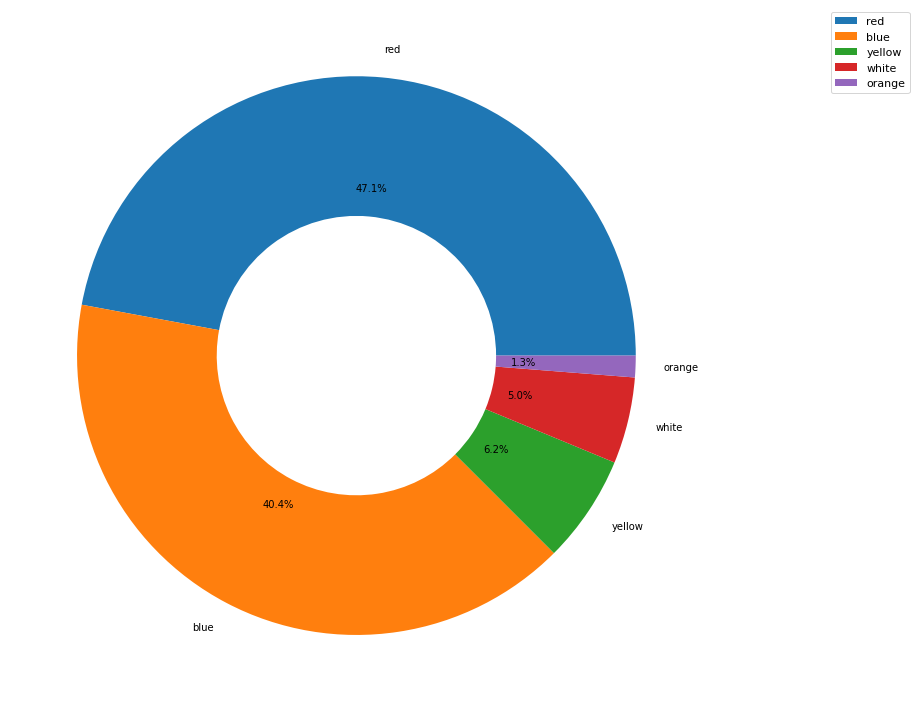

In [15]:
pie_chart(data, 'star_color')

Чаще всего встречаются звезды красного(45%) и голубого(42%) цветов

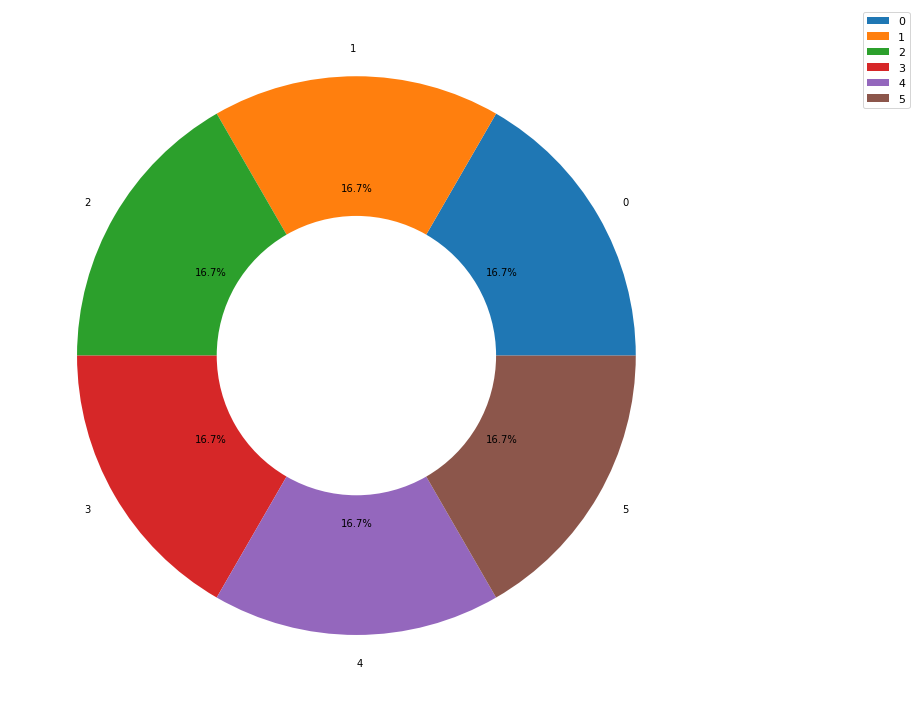

In [16]:
pie_chart(data, 'star_type')

Все пять типов звезд распределены равномерно по 20% каждый

#### Числовые признаки

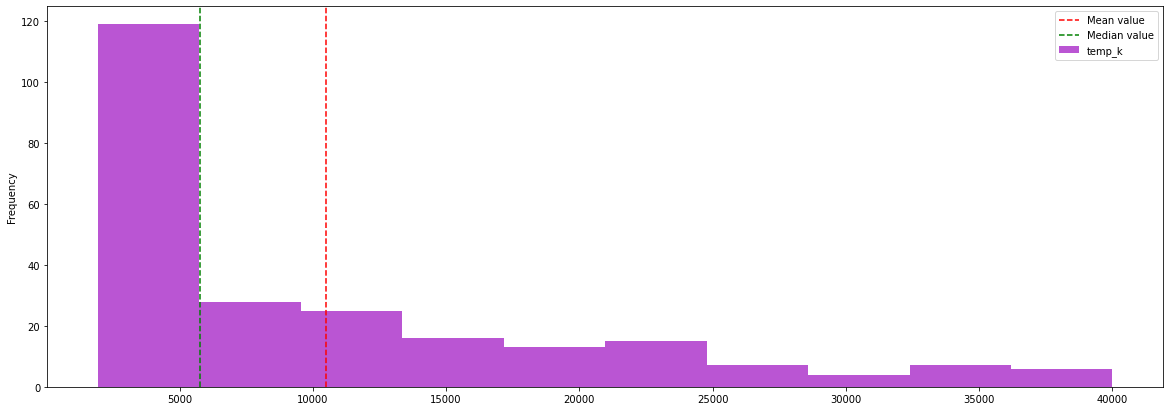

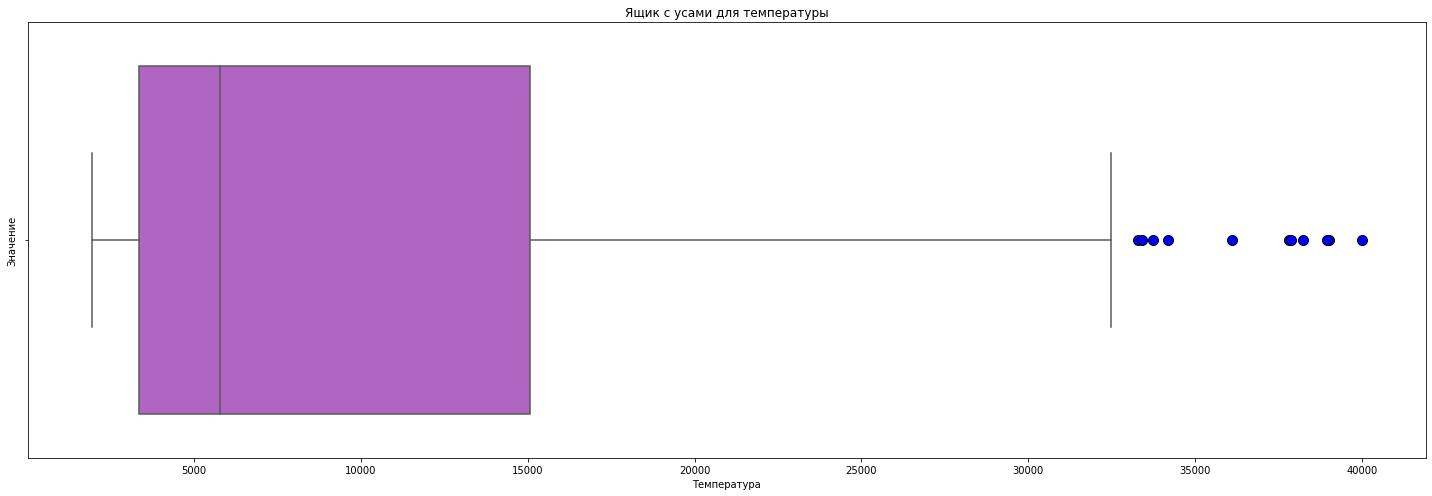

In [49]:
hist_chart(data, 'temp_k')
boxplot_chart(data, 'temp_k', 'Ящик с усами для температуры', 'Температура', 'Значение')

Средняя температура звезд ~10000 К., больше всего звезд находится в пределе 5000 Кельвинов, также есть выбросы при значении более 30000 Кельвинов, удалять их не буду, так как это целевой признак. Распределение ассиметричное вправо

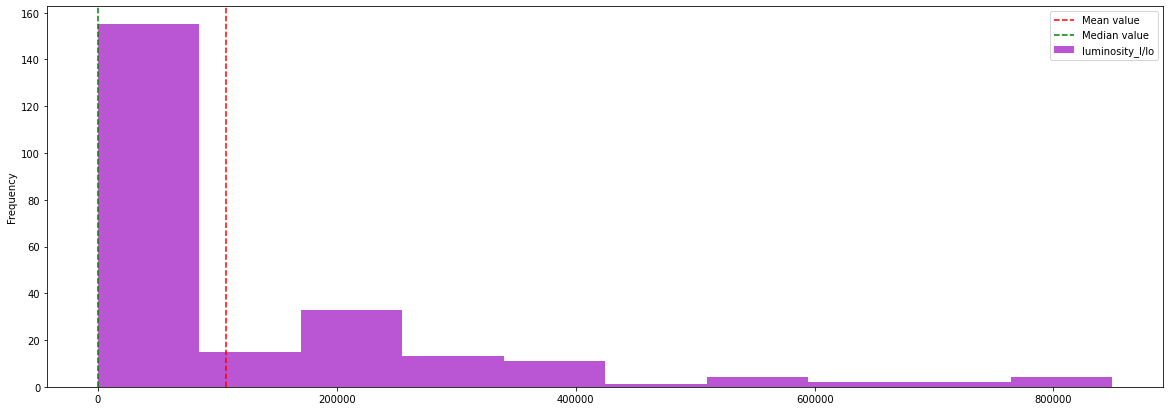

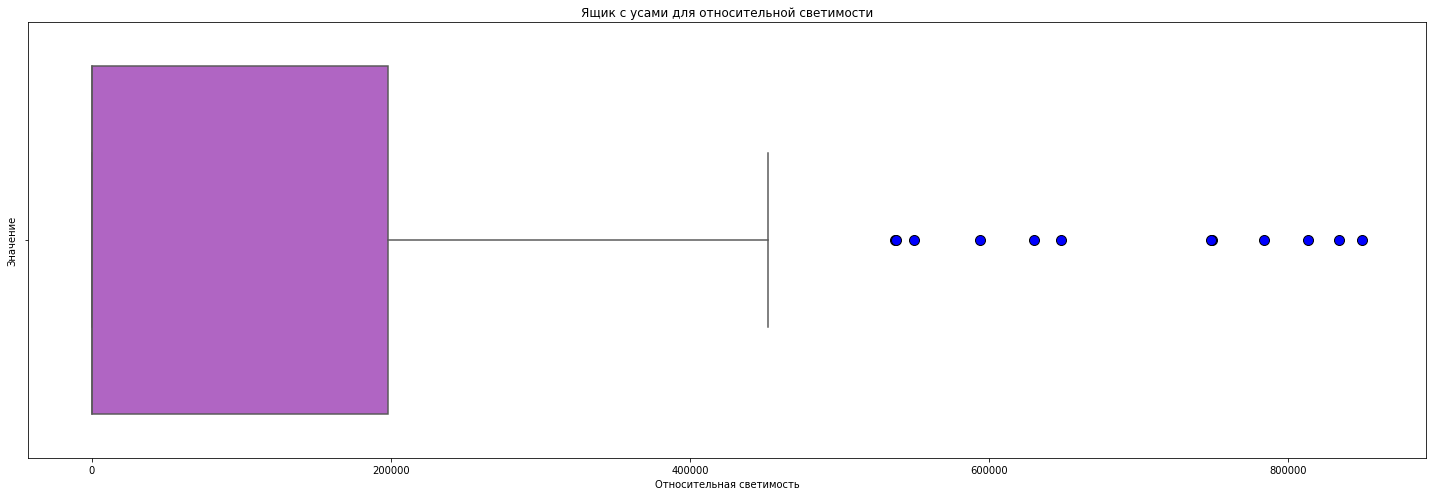

In [50]:
hist_chart(data, 'luminosity_l/lo')
boxplot_chart(data, 'luminosity_l/lo', 'Ящик с усами для относительной светимости', 'Относительная светимость', 'Значение')

Средняя относительная светимость звезд относительно Солнца ~80000 L/Lo, большинство звезд находится со значениями до 100000 L/Lo. От значения 100000 и выше можно увидеть много выбросов, удалять их не буду, данных и так немного, удаление повлияет на качество модели. Распределение ассиметричное вправо

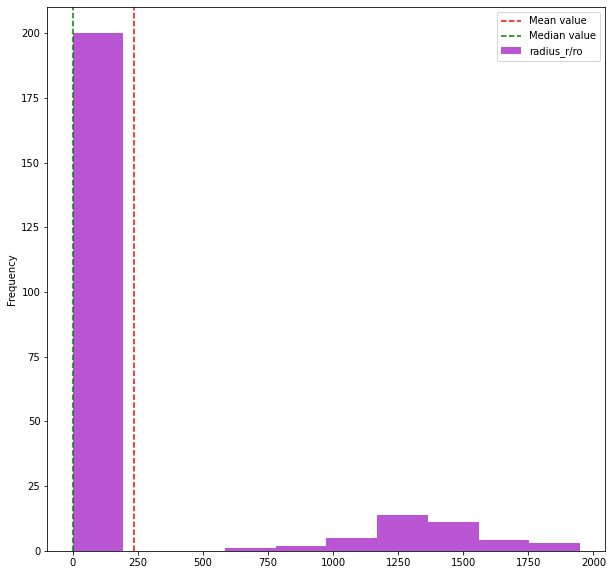

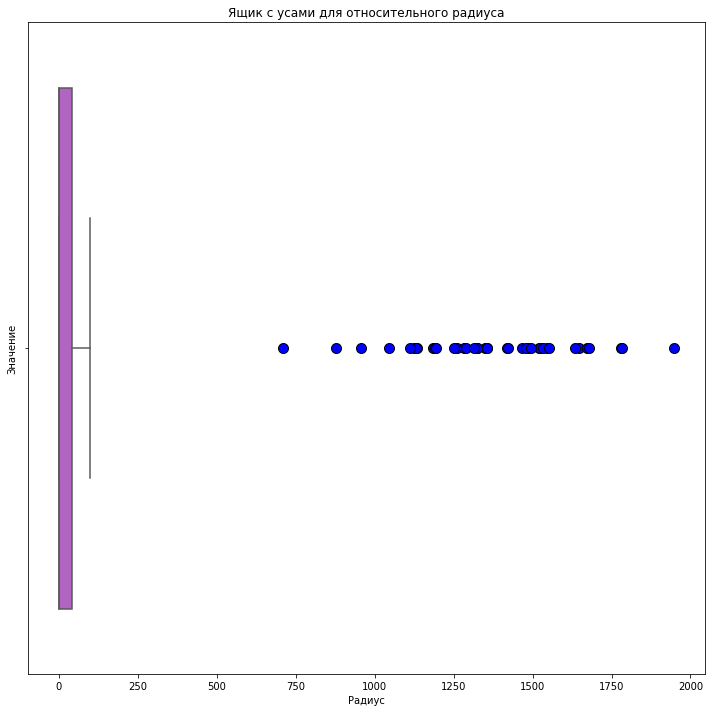

In [19]:
hist_chart(data, 'radius_r/ro')
boxplot_chart(data, 'radius_r/ro', 'Ящик с усами для относительного радиуса', 'Радиус', 'Значение')

Средний относительный радиус звезд ~13-14 R/Ro, большинство звезд имеют радиус до 10 R/Ro. Данные уже очищены от выбросов. Распределение ассиметричное вправо

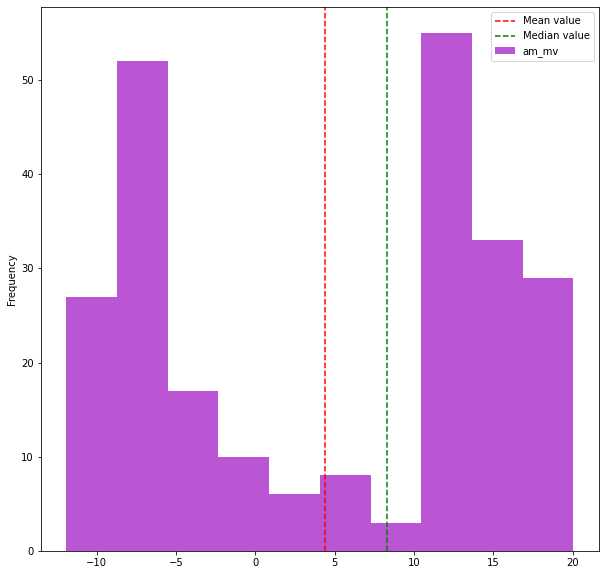

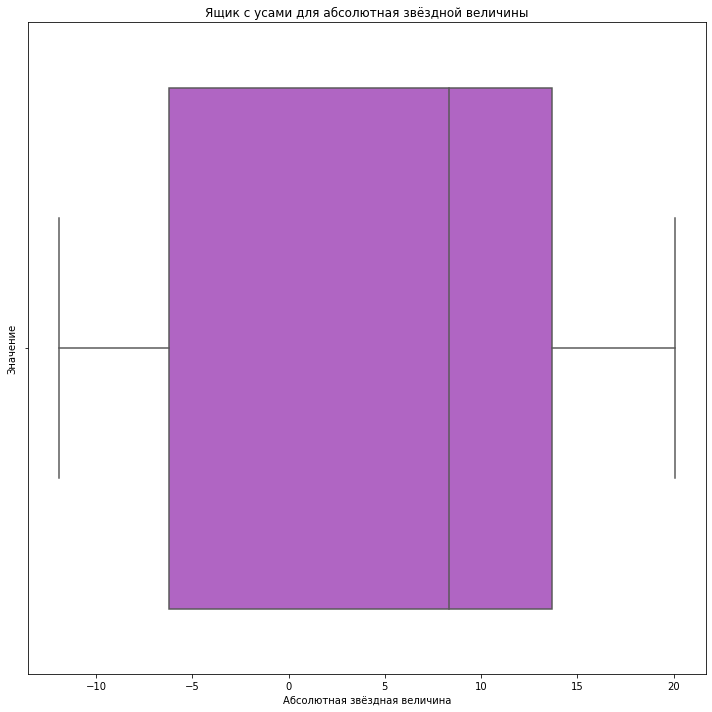

In [20]:
hist_chart(data, 'am_mv')
boxplot_chart(data, 'am_mv', 'Ящик с усами для абсолютная звёздной величины', 'Абсолютная звёздная величина', 'Значение')

Средний относительный радиус звезд ~ 7 Mv, большинство звезд имеют радиус от -7до -6 Mv и 13 Mv. Данные не содержат выбросов. Распределение двумодальное

#### Корреляции

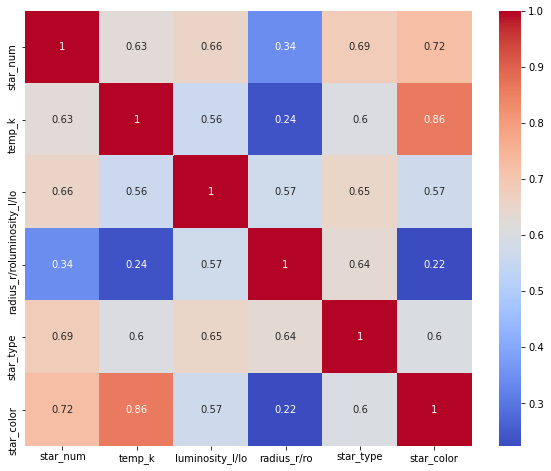

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix(data[[
    'star_num',
    'temp_k',
    'luminosity_l/lo',
    'radius_r/ro',
    'star_type',
    'star_color'
]], interval_cols=['star_num', 'temp_k', 'luminosity_l/lo', 'radius_r/ro']), annot=True, cmap='coolwarm')
plt.show()

Выведена матрица корреляций, в ней те признаки, которые будут использоваться для обучения моделей, мультиколлинеарности не наблюдается

## Построение нейронных сетей

### Подготовка данных

In [22]:
X = data.drop('temp_k', axis=1)
y = data.temp_k

In [23]:
num_cols = [
    'star_num',
    'luminosity_l/lo',
    'radius_r/ro']

cat_cols = [
    'star_type',
    'star_color'
]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)

encoder_col_names = encoder.get_feature_names()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [26]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

Данные для обучения нейронных сетей готовы: разбиты на выборки, применено масштабирование и приведены к нужному типу данных

### Простая нейронная сеть

In [27]:
def vizual(y, preds):
    preds = preds.reshape([-1]).detach().numpy()
    x = np.arange(len(y))
    
    fig, ax = plt.subplots(figsize=(17, 5)) 

    ax.bar(x, y, label='Факт', color='skyblue', edgecolor='black', alpha=0.7)
    ax.bar(x, preds, width=0.4, label='Прогноз', color='lightgreen', edgecolor='black')
    
    ax.set_title('Факт-Прогноз', fontsize=16)
    ax.set_xlabel('Номер звезды', fontsize=14)
    ax.set_ylabel('Температура звезды (K)', fontsize=14)
    ax.set_xticks(x)
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()

In [28]:
def learning_fn_baseline(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    num_epochs = 13000
    best_rmse = float('inf')
    for epoch in range(num_epochs):
        net.train()
        optimizer.zero_grad()
        train_preds = net(X_train).flatten()
        train_loss = loss_fn(train_preds, y_train)
        train_loss.backward()
        optimizer.step()
    
        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            with torch.no_grad():
                test_preds = net(X_test).flatten()
                test_rmse = torch.sqrt(loss_fn(test_preds, y_test))
                print(f'Epoch {epoch:4d} | Train Loss: {train_loss.item():.4f} | Test RMSE: {test_rmse.item():.4f}')

                if test_rmse < best_rmse:
                    best_rmse = test_rmse

    print(f'Best Test RMSE: {best_rmse.item():.4f}')
    print(f'{"="*40}')
    vizual(y_test, test_preds)

In [29]:
def learning_fn_improvement(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    num_epochs = 10000
    train_loader = DataLoader(train_dataset, batch_size=103, shuffle=True) 
    best_rmse = float('inf')
    for epoch in range(num_epochs):
        net.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            train_preds = net(X_train).flatten()
            train_loss = loss_fn(train_preds, y_train)
            train_loss.backward()
            optimizer.step()
    
        if epoch % 50 == 0 or epoch == num_epochs - 1:
            net.eval()
            with torch.no_grad():
                test_preds = net(X_test).flatten()
                test_rmse = torch.sqrt(loss_fn(test_preds, y_test))
                print(f'Epoch {epoch:4d} | Train Loss: {train_loss.item():.4f} | Test RMSE: {test_rmse.item():.4f}')
        
                if test_rmse < best_rmse:
                    best_rmse = test_rmse

    print(f'Best Test RMSE: {best_rmse.item():.4f}')
    print(f'{"="*40}')
    vizual(y_test, test_preds)

In [30]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.GELU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ELU(alpha=1.0)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_normal_(self.fc4.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        return x

In [31]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 256
n_hidden_neurons_2 = 128
n_hidden_neurons_3 = 64
n_out_neurons = 1

net = Net(
    n_in_neurons,
    n_hidden_neurons_1,
    n_hidden_neurons_2,
    n_hidden_neurons_3,
    n_out_neurons
)

Epoch    0 | Train Loss: 188347792.0000 | Test RMSE: 17764.8398
Epoch   50 | Train Loss: 185392784.0000 | Test RMSE: 17629.9473
Epoch  100 | Train Loss: 157662784.0000 | Test RMSE: 16315.7197
Epoch  150 | Train Loss: 87384520.0000 | Test RMSE: 11946.8643
Epoch  200 | Train Loss: 55200480.0000 | Test RMSE: 9288.3535
Epoch  250 | Train Loss: 44125980.0000 | Test RMSE: 8570.3125
Epoch  300 | Train Loss: 37102936.0000 | Test RMSE: 8056.5073
Epoch  350 | Train Loss: 31162294.0000 | Test RMSE: 7567.5181
Epoch  400 | Train Loss: 25959690.0000 | Test RMSE: 7060.3130
Epoch  450 | Train Loss: 21558504.0000 | Test RMSE: 6609.0278
Epoch  500 | Train Loss: 17879624.0000 | Test RMSE: 6252.1831
Epoch  550 | Train Loss: 15017900.0000 | Test RMSE: 5989.0127
Epoch  600 | Train Loss: 13047100.0000 | Test RMSE: 5832.8315
Epoch  650 | Train Loss: 11832530.0000 | Test RMSE: 5739.2212
Epoch  700 | Train Loss: 11093192.0000 | Test RMSE: 5681.5488
Epoch  750 | Train Loss: 10599403.0000 | Test RMSE: 5680.1860
E

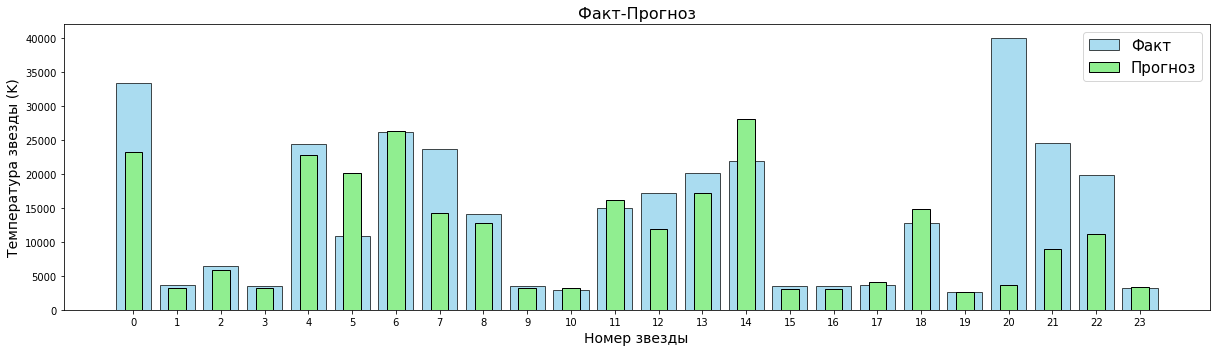

In [32]:
learning_fn_baseline(net)

Выводы по простой нейронной сети:

    Во входном слое 12 нейронов
    В двух скрытых слоях по 256, 128 и 64 соответственно
    В выходном 1 нейрон
    После слоев были выбраны функции активации: LeakyReLU, GELU, ELU соответственно
    Оптимизатор - Adam
    

Лучшая метрика RMSE на тестовой выборке во время обучения - **5047.5547**.
Простая нейронная сеть не справилась с заданием, метрика выглядит в целом нормальной с учетом аномальных значений в радиусах звезд, но для выполнения задания не подходит, на графике видна разница между тестовой выборкой и предсказанием, исправим это с помощью улучшения модели


## Улучшение нейронной сети

### Нейронная сеть с BatchNorm

In [34]:
class NetWithBatch(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NetWithBatch, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = nn.GELU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.act3 = nn.ELU(alpha=1.0)
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_normal_(self.fc4.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.fc4(x)
        return x

In [35]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 256
n_hidden_neurons_2 = 128
n_hidden_neurons_3 = 64
n_out_neurons = 1

net = NetWithBatch(
    n_in_neurons,
    n_hidden_neurons_1,
    n_hidden_neurons_2,
    n_hidden_neurons_3,
    n_out_neurons
)

Epoch    0 | Train Loss: 188246624.0000 | Test RMSE: 17758.2988
Epoch   50 | Train Loss: 179516192.0000 | Test RMSE: 17416.8730
Epoch  100 | Train Loss: 155352720.0000 | Test RMSE: 16307.4619
Epoch  150 | Train Loss: 121090904.0000 | Test RMSE: 13994.4502
Epoch  200 | Train Loss: 83429840.0000 | Test RMSE: 12508.5752
Epoch  250 | Train Loss: 50447460.0000 | Test RMSE: 10541.1338
Epoch  300 | Train Loss: 26410240.0000 | Test RMSE: 7485.3472
Epoch  350 | Train Loss: 11879957.0000 | Test RMSE: 6214.5234
Epoch  400 | Train Loss: 4891586.0000 | Test RMSE: 5723.4634
Epoch  450 | Train Loss: 2254339.7500 | Test RMSE: 5515.7036
Epoch  500 | Train Loss: 1261576.8750 | Test RMSE: 5309.8003
Epoch  550 | Train Loss: 969085.7500 | Test RMSE: 5239.0981
Epoch  600 | Train Loss: 965530.8125 | Test RMSE: 5535.0635
Epoch  650 | Train Loss: 1016962.4375 | Test RMSE: 5544.2510
Epoch  700 | Train Loss: 803668.4375 | Test RMSE: 5316.5503
Epoch  750 | Train Loss: 938491.6875 | Test RMSE: 5219.3315
Epoch  800

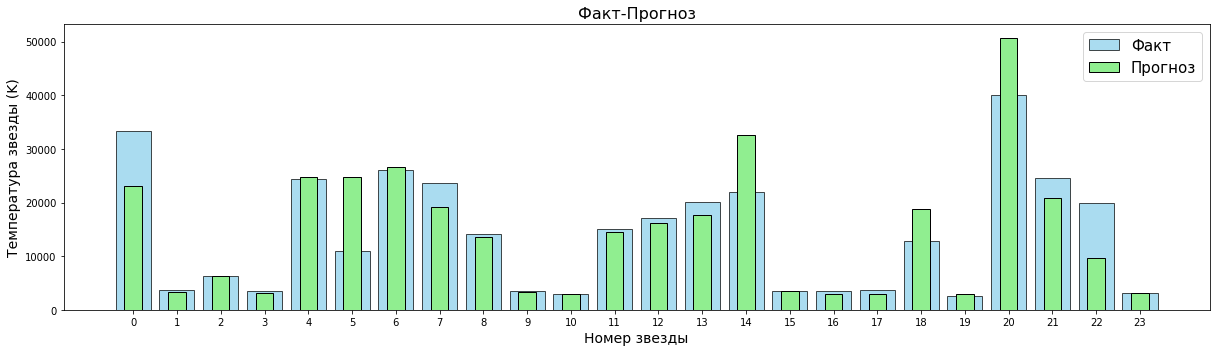

In [36]:
learning_fn_improvement(net)

С применением BatchNorm метрика RMSE осталась примерно на том же уровне **4887.5205**, также заметно что предсказания модели стали ближе к фактическим значениям и лишь у трех звезд достаточно большая ошибка, одна звезда совсем неверно предсказана

### Нейронная сеть с Dropout

In [37]:
class NetWithDrop(nn.Module):
    def __init__(self, n_in_neurons, 
                 n_hidden_neurons_1, 
                 n_hidden_neurons_2, 
                 n_hidden_neurons_3, 
                 n_out_neurons,
                 dropout_p1,  
                 dropout_p2,  
                 dropout_p3): 
        super(NetWithDrop, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.LeakyReLU(negative_slope=0.01)
        self.dp1 = nn.Dropout(dropout_p1)  
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)  
        self.act2 = nn.GELU()
        self.dp2 = nn.Dropout(dropout_p2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ELU(alpha=1.0)
        self.dp3 = nn.Dropout(dropout_p3) 
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)

        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='linear')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        x = self.fc4(x)
        return x

In [ ]:
def objective(trial):
    p1 = trial.suggest_float('dropout_p1', 0.1, 0.5, step=0.05)
    p2 = trial.suggest_float('dropout_p2', 0.1, 0.5, step=0.05)
    p3 = trial.suggest_float('dropout_p3', 0.1, 0.5, step=0.05)

    net = NetWithDrop(
        n_in_neurons = X_train.shape[1],
        n_hidden_neurons_1 = 256,
        n_hidden_neurons_2 = 128,
        n_hidden_neurons_3 = 64,
        n_out_neurons = 1,
        dropout_p1 = p1,
        dropout_p2 = p2,
        dropout_p3 = p3
    )

    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    
    train_loader = DataLoader(TensorDataset(X_train, y_train))

    best_rmse = float('inf')
    patience = 25
    no_improve = 0

    for epoch in range(8000):
        net.train()
        epoch_loss = 0

        optimizer.zero_grad()
        preds = net(X_train).flatten()
        loss = loss_fn(preds, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            net.eval()
            with torch.no_grad():
                test_preds1 = net(X_test).flatten()
                current_rmse = torch.sqrt(loss_fn(test_preds1, y_test)).item()
                
                if current_rmse < best_rmse:
                    best_rmse = current_rmse
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= patience:
                    break  

    return best_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\nBest trial:")
trial = study.best_trial
print(f"Test RMSE: {trial.value:.4f}")
print("Dropout probabilities:")
print(f"  Layer 1: {trial.params['dropout_p1']:.2f}")
print(f"  Layer 2: {trial.params['dropout_p2']:.2f}")
print(f"  Layer 3: {trial.params['dropout_p3']:.2f}")

In [39]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 256
n_hidden_neurons_2 = 128
n_hidden_neurons_3 = 64
n_out_neurons = 1
dropout_p1 = 0.45
dropout_p2 = 0.20
dropout_p3 = 0.15


net = NetWithDrop(
    n_in_neurons,
    n_hidden_neurons_1,
    n_hidden_neurons_2,
    n_hidden_neurons_3,
    n_out_neurons,
    dropout_p1,
    dropout_p2,
    dropout_p3
)

Epoch    0 | Train Loss: 188345952.0000 | Test RMSE: 17764.5078
Epoch   50 | Train Loss: 184417056.0000 | Test RMSE: 17580.6797
Epoch  100 | Train Loss: 147869824.0000 | Test RMSE: 15761.6309
Epoch  150 | Train Loss: 77645424.0000 | Test RMSE: 10828.5410
Epoch  200 | Train Loss: 55123632.0000 | Test RMSE: 9172.8828
Epoch  250 | Train Loss: 46073052.0000 | Test RMSE: 8580.8613
Epoch  300 | Train Loss: 41698620.0000 | Test RMSE: 8164.2837
Epoch  350 | Train Loss: 38595304.0000 | Test RMSE: 7777.8350
Epoch  400 | Train Loss: 33974300.0000 | Test RMSE: 7457.5527
Epoch  450 | Train Loss: 30744312.0000 | Test RMSE: 7147.5566
Epoch  500 | Train Loss: 31897690.0000 | Test RMSE: 6897.2539
Epoch  550 | Train Loss: 29187134.0000 | Test RMSE: 6662.3179
Epoch  600 | Train Loss: 24417636.0000 | Test RMSE: 6360.7251
Epoch  650 | Train Loss: 23341770.0000 | Test RMSE: 6226.6191
Epoch  700 | Train Loss: 26560534.0000 | Test RMSE: 6030.3979
Epoch  750 | Train Loss: 25908078.0000 | Test RMSE: 5859.9478
E

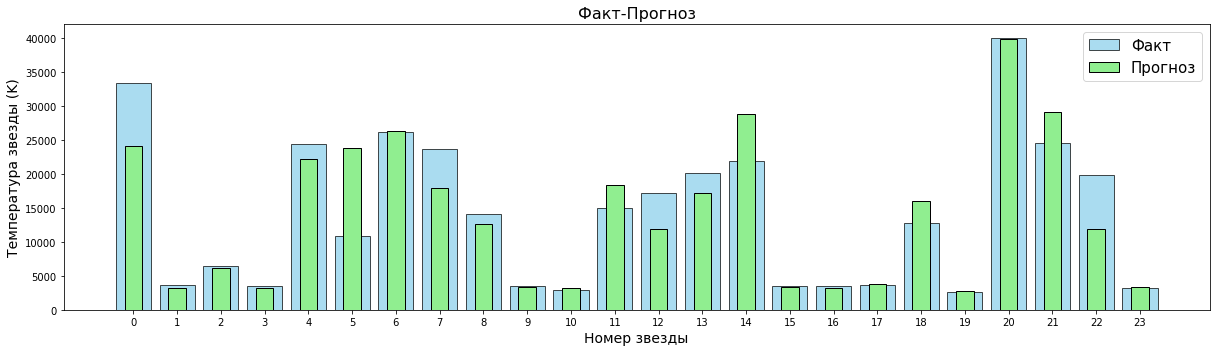

In [40]:
learning_fn_baseline(net)

С применением Dropout метрика составляет **4311.3613**, также видно, что модель предсказывает точнее всего и хорошо справляется с аномальными значениями

## Выводы

Итоги обучения:

Общие параметры для всех трех нейронных сетей:

    Во входном слое 12 нейронов
    В двух скрытых слоях по 256, 128 и 64 соответственно
    В выходном 1 нейрон
    После слоев были выбраны функции активации: LeakyReLU, GELU, ELU соответственно
    Оптимизатор - Adam

Результаты обучения простой нейронной сети:

    Метрика RMSE - 5047, модель не справилась с заданием и есть сильные расхождения на графике факт-прогноза

Результаты обучения нейронной сети с применением BatchNorm:

    Метрика RMSE - 4848, модель не справилась с заданием, но расхождения на графике уже меньше и я считаю, что 
    ее можно использовать в предсказаниях температуры

Результаты обучения нейронной сети с применением Dropout:

    Метрика RMSE - 4311, модель удовлетворяет условия задачи, по сравнению с другими нейронными сетями, лучше всего
    справляется с предсказаниями и неплохо с предсказаниями температуры у звезд с аномальными радиусами

В общем, только одна нейронная сеть подходит для определения температуры на поверхности звезд, это нейронная сеть с применением DropOut, у нее относительно самые низкие расхождения на графике, она лучше всех подстраивается под данные, также можно использовать модель вторую модель, хоть она не удовлетворяет условия задачи.